Run 1


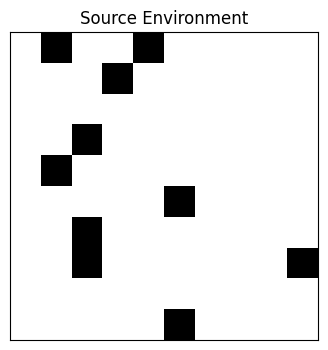


 Cumulative improvement: 55/100 runs (55.00%) 



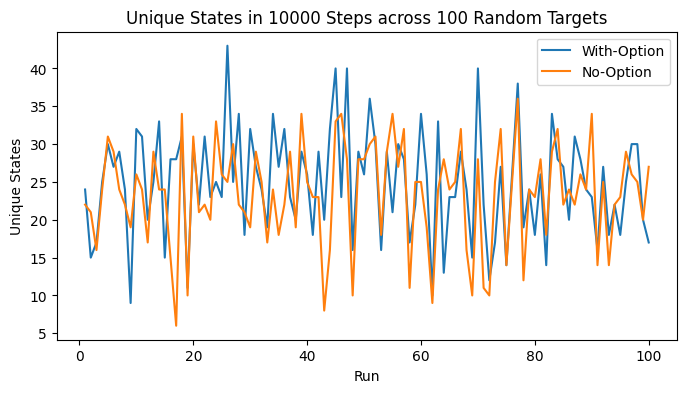




######



Run 2


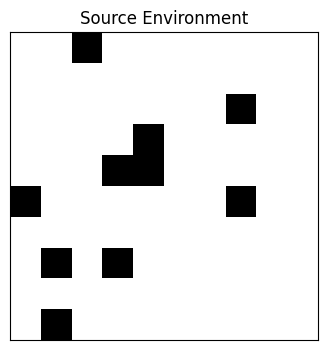


 Cumulative improvement: 99/100 runs (99.00%) 



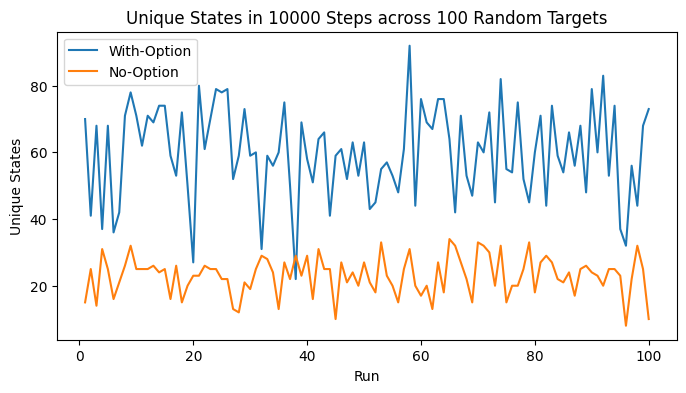




######



Run 3


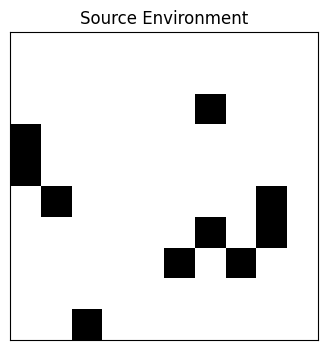


 Cumulative improvement: 98/100 runs (98.00%) 



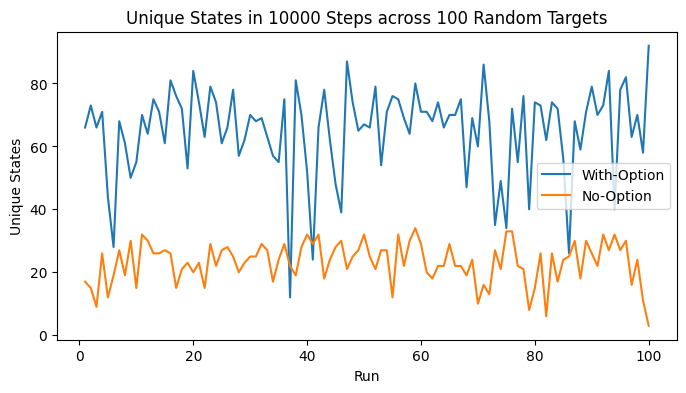




######



Run 4


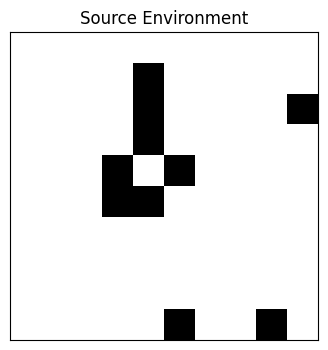


 Cumulative improvement: 67/100 runs (67.00%) 



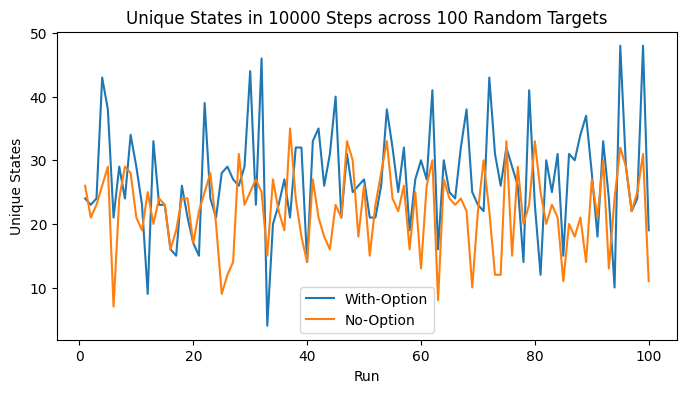




######



Run 5


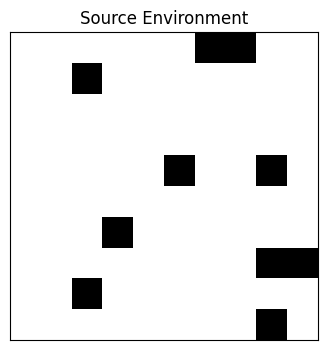


 Cumulative improvement: 100/100 runs (100.00%) 



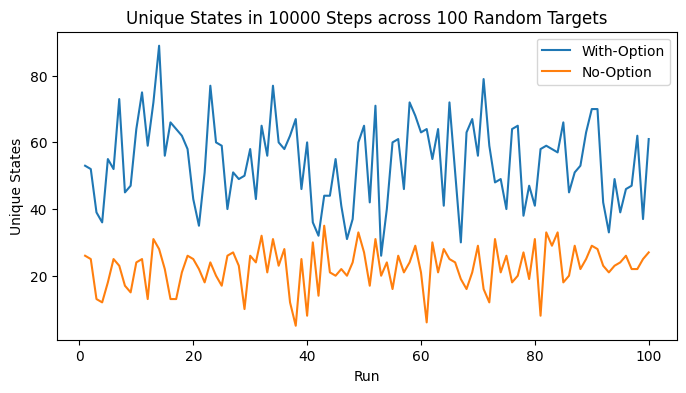




######



Run 6


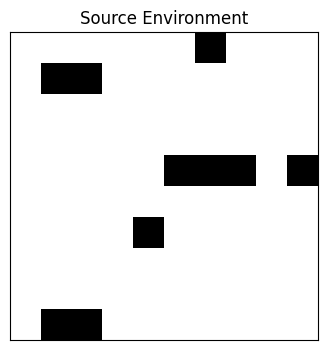


 Cumulative improvement: 76/100 runs (76.00%) 



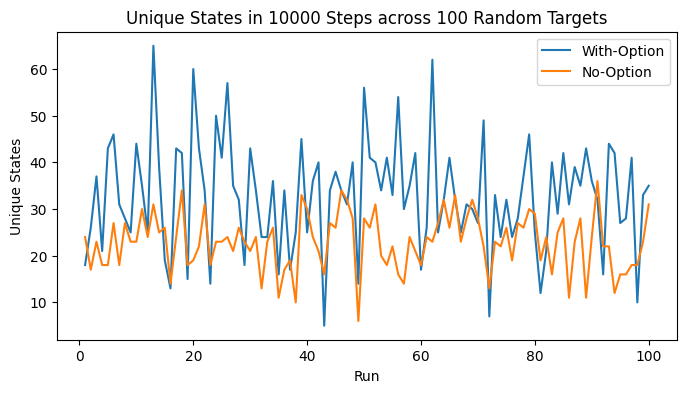




######



Run 7


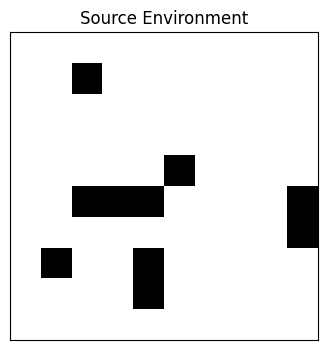


 Cumulative improvement: 99/100 runs (99.00%) 



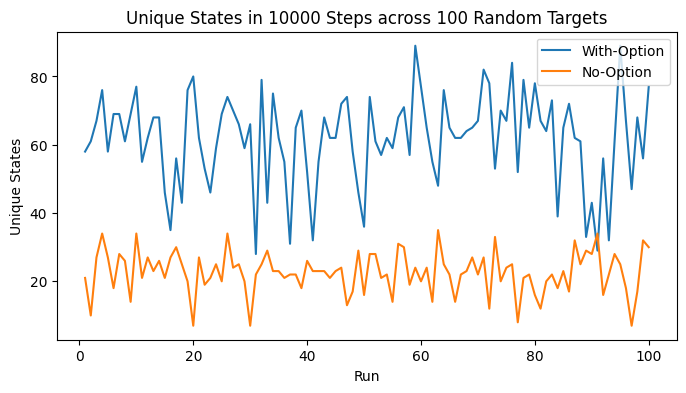




######



Run 8


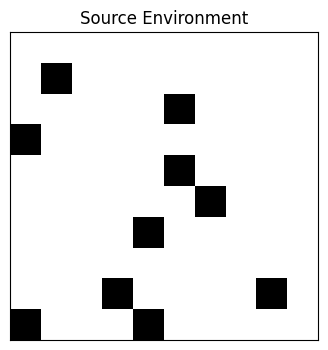


 Cumulative improvement: 100/100 runs (100.00%) 



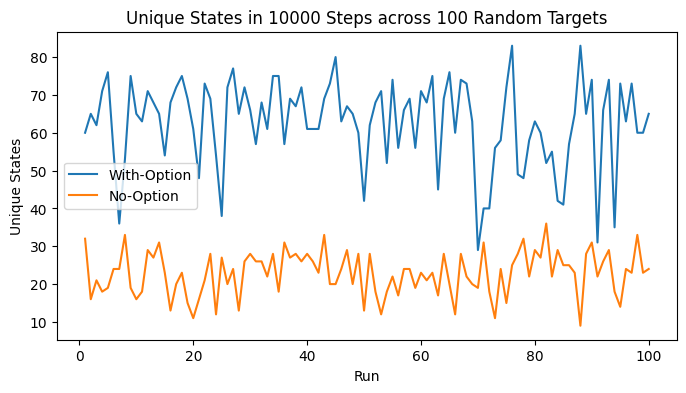




######



Run 9


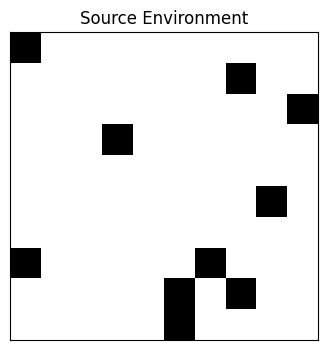


 Cumulative improvement: 73/100 runs (73.00%) 



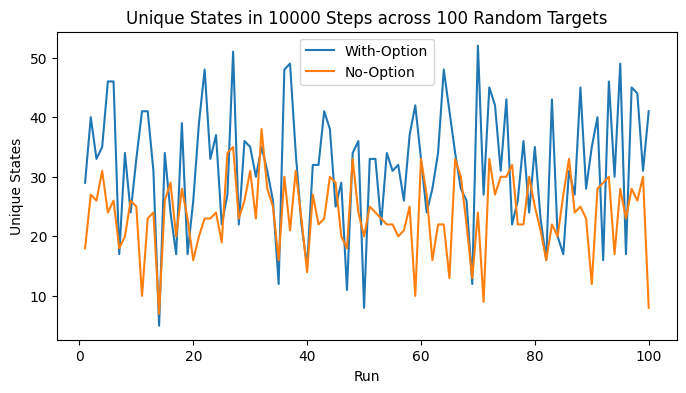




######



Run 10


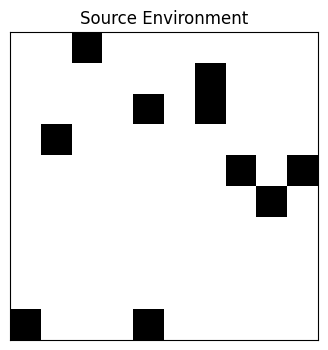


 Cumulative improvement: 98/100 runs (98.00%) 



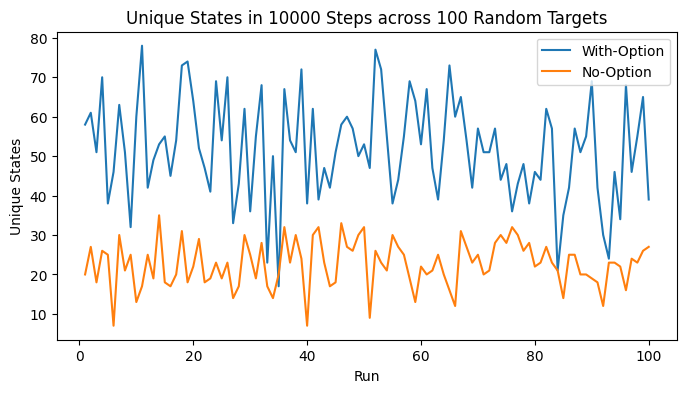




######





In [20]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# -- Custom Grid Environment with Fixed Number of Walls --
class GridEnv:
    def __init__(self, seed=None, num_walls=10, width=10, height=10):
        # Randomize if no seed provided
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
        grid = np.zeros((height, width), dtype=int)
        all_cells = [(x,y) for y in range(height) for x in range(width)]
        wall_cells = random.sample(all_cells, min(num_walls, len(all_cells)-1))
        for x,y in wall_cells:
            grid[y,x] = 1
        # Ensure connectivity
        free = [(x,y) for y in range(height) for x in range(width) if grid[y,x]==0]
        queue = deque([free[0]]); visited = {free[0]}
        while queue:
            x,y = queue.popleft()
            for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]:
                nx,ny = x+dx, y+dy
                if 0<=nx<width and 0<=ny<height and grid[ny,nx]==0 and (nx,ny) not in visited:
                    visited.add((nx,ny)); queue.append((nx,ny))
        # Remove isolating walls
        for x,y in wall_cells:
            neighbors = [(x+dx,y+dy) for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]]
            if not any((nx,ny) in visited for nx,ny in neighbors if 0<=nx<width and 0<=ny<height):
                grid[y,x] = 0
        self.grid = grid
        self.state_positions = [(x,y) for y in range(height) for x in range(width) if grid[y,x]==0]
        self.pos2state = {pos:i for i,pos in enumerate(self.state_positions)}
        self.n_states = len(self.state_positions)
        self.actions = [(1,0),(-1,0),(0,1),(0,-1)]
        self.width = width; self.height = height

    def reset(self):
        return random.randrange(self.n_states)

    def step(self, s, a):
        x,y = self.state_positions[s]
        dx,dy = self.actions[a]
        nx,ny = x+dx, y+dy
        return (self.pos2state[(nx,ny)],0,False,{}) if (nx,ny) in self.pos2state else (s,0,False,{})

    def render(self, ax=None, title=""):
        if ax is None: _, ax = plt.subplots()
        ax.imshow(self.grid, cmap='Greys', origin='upper')
        ax.set_xticks([]); ax.set_yticks([])
        if title: ax.set_title(title)
        return ax

# -- Agent-Space Feature Encoding --
def agent_features(env):
    S = env.n_states; feats = np.zeros((S,6))
    W,H = env.width, env.height
    for s,(x,y) in enumerate(env.state_positions):
        feats[s,0] = x/(W-1); feats[s,1] = y/(H-1)
        feats[s,2] = 1 if (x+1,y) not in env.pos2state else 0
        feats[s,3] = 1 if (x-1,y) not in env.pos2state else 0
        feats[s,4] = 1 if (x,y+1) not in env.pos2state else 0
        feats[s,5] = 1 if (x,y-1) not in env.pos2state else 0
    return feats

# -- Feature Eigenvectors from SR --
def compute_feature_eigenvectors(env, gamma=0.9, topk=4):
    P = np.zeros((env.n_states, env.n_states))
    for s,_pos in enumerate(env.state_positions):
        x,y = env.state_positions[s]
        for dx,dy in env.actions:
            ns = env.pos2state.get((x+dx,y+dy), s)
            P[s,ns] += 1/len(env.actions)
    M = np.linalg.inv(np.eye(env.n_states) - gamma*P)
    Phi = agent_features(env)
    C = Phi.T @ (M @ M.T) @ Phi
    eigvals,eigvecs = np.linalg.eig(C)
    idx = np.argsort(-eigvals.real)[:topk]
    return [eigvecs[:,i].real for i in idx]

# -- Build Options from Eigenvector --
def build_options(env,u):
    Phi = agent_features(env); vals = Phi @ u
    policy,term = {}, set()
    for s,(x,y) in enumerate(env.state_positions):
        best_val,best_a = vals[s], None
        for a,(dx,dy) in enumerate(env.actions):
            ns = env.pos2state.get((x+dx,y+dy),None)
            if ns is not None and vals[ns]>best_val:
                best_val,best_a = vals[ns],a
        if best_a is None: term.add(s)
        else: policy[s] = best_a
    return policy,term

# -- Transfer Options from Source to Target --
def transfer_options(env_src,env_tgt,gamma=0.9,topk=4):
    us = compute_feature_eigenvectors(env_src,gamma,topk)
    return [build_options(env_tgt,u) for u in us]

# -- Unique States in Fixed Horizon --
def simulate_unique_states(env, options=None, use_options=False,
                           horizon=10000, epsilon=0.1,
                           p0=0.9,p_decay=0.995,
                           option_execution_decay=0.99):
    s = env.reset(); visited = {s}
    q = np.zeros((env.n_states,len(env.actions)))
    p,in_opt,cur_opt = p0, False, None
    # Introduce option strength to implement the decaying effect
    cur_opt_strength = 0
    for step in range(1,horizon+1):
        a=None
        if use_options and in_opt:
            if s in options[cur_opt][1]:
                in_opt = False; cur_opt = None; cur_opt_strength = 0
            else:
                a = options[cur_opt][0].get(s)
                # Decay the strength of the current option
                cur_opt_strength *= option_execution_decay
                # Abandon the option based on decayed strength
                if random.random() > cur_opt_strength:
                    in_opt = False; cur_opt = None; cur_opt_strength = 0
        if not in_opt:
            if use_options and random.random()<p:
                cur_opt = random.randrange(len(options))
                in_opt = True
                cur_opt_strength = 1  # initialize option strength
                a = options[cur_opt][0].get(s)
            if a is None:
                a = random.randrange(len(env.actions)) if random.random()<epsilon else int(q[s].argmax())
        s,_,_,_ = env.step(s,a); visited.add(s)
        q[s,a] += 0.1*(0 + 0.99*q[s].max() - q[s,a])
        p*=p_decay
    return len(visited), horizon

# -- Main Experiment: 100 Random Targets --
def main():
    # Fixed source environment
    env_src = GridEnv(num_walls=10)
    # Render source once
    fig, ax = plt.subplots(figsize=(4,4))
    env_src.render(ax=ax, title='Source Environment')
    plt.show()

    n_runs = 100
    unique_base = []
    unique_opt  = []

    for i in range(1, n_runs+1):
        # Generate a new random target per run (no fixed seed)
        env_tgt = GridEnv(num_walls=10)
        # Option transfer
        opts = transfer_options(env_src, env_tgt)
        # Simulations
        ub, _ = simulate_unique_states(env_tgt, use_options=False)
        uo, _ = simulate_unique_states(env_tgt, options=opts, use_options=True)
        unique_base.append(ub)
        unique_opt.append(uo)
        perc = (uo-ub)/ub*100 if ub>0 else 0
        # print(f"Run {i}: No-Option {ub}, With-Option {uo}, Improvement {perc:.2f}%")

    # Cumulative improvement
    imp_count = sum(1 for ub,uo in zip(unique_base,unique_opt) if uo>ub)
    imp_pct = imp_count/n_runs*100
    print(f"\n Cumulative improvement: {imp_count}/{n_runs} runs ({imp_pct:.2f}%) \n")

    # Plot summary
    runs = np.arange(1, n_runs+1)
    plt.figure(figsize=(8,4))
    plt.plot(runs, unique_opt, label='With-Option')
    plt.plot(runs, unique_base, label='No-Option')
    plt.title('Unique States in 10000 Steps across 100 Random Targets')
    plt.xlabel('Run'); plt.ylabel('Unique States'); plt.legend(); plt.show()

    print("\n\n\n######\n\n\n")


for i in range(1,11):
    print(f"Run {i}")
    main()